In [5]:
from statsmodels.stats.power import TTestIndPower

# parameters for power analysis
# effect_size has to be positive


# 1. Determine sample size, sample_size = (16*sigma^2)/delta^2
# sigma = sample variance is determined through an AA test, by
# splitting the samples into two groups and then assign the same treatment to both

# delta = the difference between control and treatment groups


effect = 0.1  # standardized effect size, difference between the two means divided by the standard deviation
alpha = 0.05
power = 0.8

# perform power analysis first
analysis = TTestIndPower()

result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha = alpha)
# The function gives out the value of the parameter that was set to None in the call

# "nobs1": number of observations of sample 1. 
# The number of observations of sample two is ratio times the size of sample 1, i.e. nobs2 = nobs1 * ratio
# "ratio": ratio of the number of observations in sample 2 relative to sample 1.
# "power": power of the test, e.g. 0.8, is one minus the probability of a type II error. 
# Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.
# "alpha": significance level, e.g. 0.05, is the probability of a type I error,


# the computed number of samples required for each variant of the experiment.

print('Sample Size: %.3f' % round(result))

Sample Size: 1571.000


In [47]:
# simulate data. Five variables are simulated:
# 1. userid
# 2. version
# 3. minutes of play
# 4. user engagement after 1 day
# 5. user engagement after 7 days

# We will simulate 1600 control units and 1749 treated units

# Variable # 1: userid
user_id_control = list(range(1,1601))
user_id_treatment = list(range(1601,1601+1749))

print(len(user_id_control))
print(len(user_id_treatment))


# Variable # 2: version
import numpy as np
control_status = ['control']*1600
treatment_status = ['treatment']*1749

# Variable # 3: minutes of play ~ N(mu1=30minutes, sigma1^2=10)
# Based on the definition of MDE (Minimum Detectable Effect) = (mu_1 - mu_2)/sigma^2
# Considering mu_1=30, MDE = 0.1 and sigma2^2=10, mu_2 will compute as 31
mu_1 = 30; sigma1_squared = 10
minutes_control = np.random.normal(loc=mu_1, scale=sigma1_squared, size=1600)

mu_2 = 31; sigma2_squared = 10
minutes_treatment = np.random.normal(loc=mu_2, scale=sigma2_squared, size=1749)



# Variable # 4: user engagement after 1 day (metric 1)
# We assume that control group has 30% active (True) and 70% inactive (False) users after 1 day
# Also we assume that the treatment group has 35% active and 65% inactive users
active_status = [True, False]
day_1_control = np.random.choice(active_status, 1600, p=[0.3, 0.7])
day_1_treatment = np.random.choice(active_status, 1749, p=[0.35, 0.65])


# Variable # 5: user engagement after 7 days (metric 2)
# We assume that control group has 35% active (True) after 7 days
# Also we assume that the treatment group has 25% active
day_7_control = np.random.choice(active_status, 1600, p=[0.35, 0.65])
day_7_treatment = np.random.choice(active_status, 1749, p=[0.25, 0.75])



# Form dataframes from simulated variables
import pandas as pd
raw_control = {'user_id':user_id_control,
               'version':control_status,
               'minutes_play':minutes_control,
               'day_1_active':day_1_control,
               'day_7_active':day_7_control
                }

control_group = pd.DataFrame(data = raw_control)
control_group


raw_treatment = {'user_id': user_id_treatment,
                 'version':treatment_status,
                 'minutes_play':minutes_treatment,
                 'day_1_active': day_1_treatment,
                 'day_7_active':day_7_treatment}
treatment_group = pd.DataFrame(data= raw_treatment)
treatment_group

1600
1749


,user_id,version,minutes_play,day_1_active,day_7_active
0,1601,treatment,27.402511,False,False
1,1602,treatment,26.328132,False,False
2,1603,treatment,32.960470,False,False
3,1604,treatment,39.006769,False,False
4,1605,treatment,38.456182,False,True
...,...,...,...,...,...
1744,3345,treatment,18.178110,True,True
1745,3346,treatment,29.897803,False,False
1746,3347,treatment,21.512957,True,False
1747,3348,treatment,41.211080,True,False


Text(0, 0.5, 'User Count')

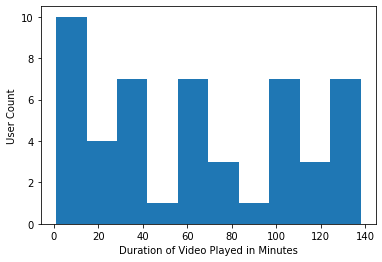

In [58]:
 # Step 3: data analysis
    
# 3.1. check how many users fell into each variant.
final_data = [control_group, treatment_group]

final_data = pd.concat(final_data)
from sklearn.utils import shuffle
final_data = shuffle(final_data)
final_data.head()

# first we check how many samples of each group we have
final_data.groupby('version')['user_id'].count()
# the group sizes are not equal: we should be suspicious now.

# To formally check for the Sample Ratio Mismatch, SRM, we conduct a chi-square test between 
# the actual split and the expected split of the treated and control units (Kohavi et al. 2020).
from scipy.stats import chisquare
chisquare(f_obs = [1600, 1749], f_exp = [1675, 1674])
# f_obs: observed frequencies in each category.
# f_exp: expected frequencies in each category. By default the categories are assumed to be equally likely.

# We set the alpha level at 0.001 to test SRM. Since the p-value is < 0.01,
# we fail to reject the null hypothesis and we can conclude there is no evidence of SRM.
# In contrast to our intuition, statistical tests conclude that the treatment assignment works as expected.



%matplotlib inline
final_data['minutes_play_integers'] = round(final_data['minutes_play'])
plot_df = final_data.groupby('minutes_play_integers')['user_id'].count()
# Plot the distribution of players that played 0 to 50 minutes
ax = plot_df.head(n=50).plot(x='minutes_play_integers', y='user_id', kind='hist')
ax.set_xlabel('Duration of Video Played in Minutes')
ax.set_ylabel('User Count')

<AxesSubplot:ylabel='Density'>

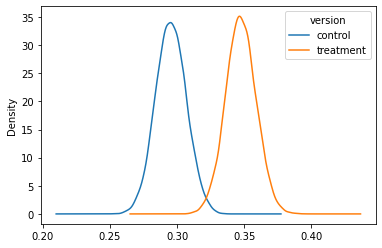

In [62]:
#  Metric 1: 1-day retention by AB-Group

final_data['day_1_active'].mean()
# After 1 day, the overall active user rate, on average, hovers around 32.5%

final_data.groupby('version')['day_1_active'].mean()

# After ovserving there is a differene between the means of the groups, we should ask the questions:

# Is the higher retention rate in the treatment group statistically significant?
# What is its variability?
# If we repeat the process for 10,000 times, how often do we observe at least as extreme values?


# To answer these questions we use the Bootstrap sampling:
boot_means = []

# run the simulation for 10k times
for _ in range(10000):
    boot_sample = final_data.sample(frac=1, replace=True).groupby('version')['day_1_active'].mean()
    boot_means.append(boot_sample)

boot_means = pd.DataFrame(boot_means)
# kernel density estimate
boot_means.plot(kind='kde')

Text(0.5, 0, '% diff in means')

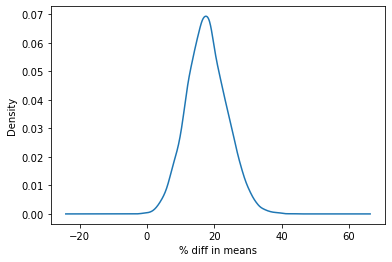

In [66]:
# create a new column, diff, as the difference between the two variants, scaled by the control group
boot_means['diff'] = (boot_means['treatment'] - boot_means['control']) / boot_means['control'] * 100
boot_means['diff']

# plot the bootstrap sample differenccecs
ax = boot_means['diff'].plot(kind='kde')
ax.set_xlabel('% diff in means')

In [69]:
boot_means[boot_means['diff'] > 0]
# p-value
p = (boot_means['diff'] > 0).sum() / len(boot_means)
p

# Conclusion: After bootstrapping 10,000 times, the treatment has a higher 1-day retention rate 99.95% of the time.

0.9995

In [73]:
# Repeat the same for 7-day metric

boot_7d = []

for i in range(10000):
    #set frac=1 --> sample all rows
    boot_mean = final_data.sample(frac=1,replace=True).groupby('version')['day_7_active'].mean() 
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['treatment'] - boot_7d['control'])/boot_7d['control'] *100

Text(0.5, 0, '% diff in means')

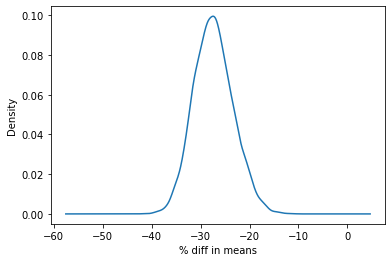

In [74]:
# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means")

In [75]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
p = (boot_7d['diff']>0).sum()/len(boot_7d)

1-p

# On the 7-day metric, the control obviously has a better user retention rate 100% of the 
# time, also consistent with the original data.

1.0

In [ ]:
### Best Practices
# 1. SRM is a real concern. We apply a chi-square test to formally test for the SRM. 
   # If the p-value is smaller than the threshold (α = 0.001), the randomization process does not work as expected.

# 2. An SRM introduces selection bias that invalidates any test results.
# 3. Three fundamental statistical concepts to master: SRM, chi-square test, and bootstrap.
# 4. Compare short-term and long-term metrics to evaluate the novelty effect.
